In [1]:
import tclab
from tclab import Plotter, clock, Historian

import numpy as np
import tbcontrol
from tbcontrol import blocksim

import matplotlib.pyplot as plt
import pandas as pd

import sympy
s = sympy.Symbol('s')

%matplotlib inline

In [2]:
Kp, τp, θp, To_p = 0.6423177737615754, 150.3121523254063, 17.396993066317368, 57.79957014481422
τc = 0.8*θp
f = 1/(τc*s+1)
G_ = Kp/(τp*s+1)
Gc_star = f*(G_)**-1

Gimc = blocksim.LTI('Gc_imc','E','P',[τp,1],[Kp*τc,Kp]) #HERE I STRUGGLE WITH tau_c
Gm = blocksim.LTI('Gc_m','P','Yt',[Kp],[τp,1])  #model is just the FOPDT fitted to our model

# diagram_imc = blocksim.Diagram([Gimc,Gm],sums={},inputs={'E': blocksim.step()})

# ts = np.linspace(0, 50, 1000)

# simulation_imc = diagram_imc.simulate(ts) #, progress = True)

# plt.plot(list(ts), simulation_imc['Yt'])
# plt.show()

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
               ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
#     p = Plotter(h, 180)
    
    for t in clock(1800):
        if t < 300:
            T1sp = 20
        else:
            T1sp = 50
        Q1 = lab.Q1(Gimc.output)
        T1 = lab.T1
        e = T1sp - (T1 - Gm.output)
        
        Gimc.change_input(t, e)
        Gimc.change_state(Gimc.state + Gimc.derivative(e))
        
        Gm.change_input(t,Gimc.output)
        Gm.change_state(Gm.state + Gm.derivative(e))
        
        h.update(t) 
#         p.update(t)

In [3]:
import control

G = Gplus*Gminus \
Gplus contains time delays and RHP zeros \

Gplus steady state gain = 1

G_imc = 1/Gminus * F

F is low pass filter 1/(tauC s +1)**r

Base model Transfer Function:
FOPDT \
G_m = K * e**-theta s /(tau*s + 1)

In [4]:
def set_point(t):
    if t>300:
        return 50
    else:
        return 20

In [5]:
K = 0.6423
tau = 150.312
theta = 17.397

In [6]:
s = control.TransferFunction([1,0],[1])
s


s
-
1

In [7]:
model_tf = K/(tau*s +1) #PLUS DEADTIME

In [42]:
r = 1
tau_c = 0.1
F = 1/(tau_c*s + 1)**r

In [43]:
# G_plus = (np.exp**(-theta*s))

In [44]:
G_minus = model_tf

In [45]:
IMC_tf = (1/G_minus) * F



In [57]:
run_time = 1800
bias = 0
bias_T = 20

In [58]:
# simulate zero-error run to get initial state vector
T, yout, xout = control.forced_response(IMC_tf, [0, 1], None, transpose=True)

# get initial state vector
xcc = xcm = xout[-1]

In [59]:
TCLab = tclab.setup(connected=False, speedup=10)
model_predictions = []
errors = []
controller_outputs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

with TCLab() as lab:
    sources = lab.sources
    h = tclab.Historian(sources)
    
    prev_t = -1
    
    error = set_point(0) - lab.T1
    
    for t in clock(run_time):  # change to tclab.clock(steptime=steptime) to sync with time
        # Figure out how much time has gone by since previous clock tick
        # Note in the simulation case this will always be `steptime`, but when we sync
        # it may not be, so we have to calculate correctly
        Δt = t - prev_t
        prev_t = t
#         print(-int(theta/Δt)-1)
        
        # integrate controller assuming error stays constant over timestep (zero-order-hold)
        # notice we're using the error from the previous time step, 
        # because we're simulating from one step ago to right now.
        _, yout, xout = control.forced_response(IMC_tf, [0, Δt], [error, error], xcc, transpose=True)
        
        controller_output = yout[-1] + bias
        controller_outputs.append(controller_output)
        xcc = xout[-1]
        
        
        # predict model
        _, ymout, xmout = control.forced_response(model_tf, [0, Δt], [controller_outputs[-int(theta/Δt)-1], controller_outputs[-int(theta/Δt)]], xcm, transpose=True)
        
        model_predictions.append((ymout[-1])+bias_T)
        xcm = xmout[-1]
        
        # communicate with tclab
        # We read the error at "the same time" as we write
        # This ensures that the controller uses only information from the previous time step
        error = set_point(t) - (lab.T1 - (ymout[-1] + bias))
        errors.append(error)
                
        # write out to tclab
#         lab.Q2(disturbance(t))
        lab.Q1(controller_output)
        
        # update historian
        h.update(t)
        lab.update(t)  # for the real lab this is not required

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


In [60]:
set_points = []
for t in h.t:
    set_points.append(set_point(t))

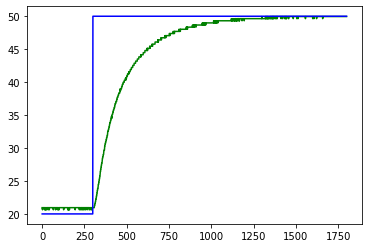

In [63]:
plt.plot(h.t, h.logdict["T1"] , 'g')
# plt.plot(h.t, h.logdict["Q1"] , 'c')
plt.plot(h.t, set_points, 'b')
# plt.plot(h.t, model_predictions, 'y')
# plt.plot(h.t, errors, 'r')